In [1]:
c = 3e8  # speed of light (m/s)
fc = 10e9  # Carrier frequency: 10 GHz
wavelength = c / fc
bandwidth = 100e6  # 100 MHz
tx_power_dbm = 30  #  dBm
jam_power_dbm = 50
k = 1.38e-23  # Boltzmann 
GT = 13 # db gain-to-noise-temperature for for 0.33m Equivalent satellite antenna aperturesatellites, or can be 5 dB K^(-1) for 0.13m Equivalent satellite antenna aperture
La = 5 # dB
GT_linear_inv = 10 ** (-GT / 10)
La_linear = 10 ** (La / 10)
noise_power_watt = k * bandwidth * GT_linear_inv * La_linear
Tx_power_watt = 10 ** ((tx_power_dbm  - 30)/ 10)  
Jam_power_watt = 10 ** ((jam_power_dbm  - 30)/ 10)

In [2]:
from leo_utils import arc_point_on_earth, compute_satellite_intersection_point_enu, compute_az_el_dist
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from minmax_solvers import (
    solve_game_mirror_prox,
    solve_game_bestresp_Q0_then_Q1,
    solve_game_proxBR,
    solve_game_extragradient,
    solve_game_pdhg,
    solve_game_proxBR_pp
)
# Your utils
from leo_utils import arc_point_on_earth, compute_satellite_intersection_point_enu
from sionna.rt import PlanarArray


import numpy as np
from numpy.linalg import cholesky, solve, eigh


# Generate RX positions

distances_km = [1]
azimuths_deg = np.linspace(0, 360, len(distances_km), endpoint=False)
gnd_positions = [np.array([0.0, 0.0, 0.0])]

for d_km, az in zip(distances_km, azimuths_deg):
    pos = arc_point_on_earth(d_km, az)
    gnd_positions.append(pos)
gnd_positions = np.array(gnd_positions)

for i, pos in enumerate(gnd_positions):
    print(f"TX{i}(m): {pos}")


# Compute SAT intersection points

sat_orbit_m = 450e3
angles = [(117.88, 56.2),(230.22, 72.96), (198,60.5),(345.49,65.65), (272.81, 60.03)]
# angles = [(1, 90-(1e-3)), (60, 87), (120,84),(180,80), (240, 82),(300,80)]
# angles = [(45, 90-(1e-3)), (120, 87), (75,85),(80,83), (65, 82),(130,80)]
# angles = [(45, 90-(1e-3)), (220, 87), (75,85)]
sat_positions = []
delays_ms = []
fspl_db = []
frequency_hz = 10e9 
wavelength = 3e8 / frequency_hz

for az, el in angles:
    pos, delay, dist = compute_satellite_intersection_point_enu(az, el, sat_orbit_m)
    sat_positions.append(pos)
    delays_ms.append(delay)
    fspl = 20 * np.log10(4 * np.pi * dist / wavelength)
    fspl_db.append(fspl)

sat_positions = np.array(sat_positions)
delays_ms = np.array(delays_ms)
fspl_db = np.array(fspl_db)

print("\nSatellite Pos [m]:\n", sat_positions)
# print("\nPropagation delays [ms]:\n", delays_ms)
# print("\nFree-space path loss [dB]:\n", fspl_db)


# Compute az/el/dist per TX-SAT
  
for i, tx in enumerate(gnd_positions):
    print(f"\nFrom TX{i}:")
    for j, sat in enumerate(sat_positions):
        az, el, dist, n_waves = compute_az_el_dist(sat, tx, frequency_hz)
        print(f"  SAT{j}: az={az:.2f}°, el={el:.2f}°, dist={dist:.2f} m, λ count ≈ {n_waves:.2f}")


jitc_llvm_init(): LLVM API initialization failed ..


TX0(m): [0. 0. 0.]
TX1(m): [ 6.12323397e-14  9.99999996e+02 -7.84806153e-02]

Satellite Pos [m]:
 [[ 262456.53585155 -138846.30621674  443534.41329918]
 [-105667.86428792  -87976.67405292  448614.02186952]
 [ -77861.13109815 -239631.92136661  445344.70860492]
 [ -50685.50241938  195845.27977748  446999.45777597]
 [-256398.35079249   12584.82879559  445167.72884845]]

From TX0:
  SAT0: az=117.88°, el=56.20°, dist=533745.73 m, λ count ≈ 17791524.38
  SAT1: az=230.22°, el=72.96°, dist=469212.25 m, λ count ≈ 15640408.25
  SAT2: az=198.00°, el=60.50°, dist=511681.27 m, λ count ≈ 17056042.36
  SAT3: az=345.49°, el=65.65°, dist=490645.40 m, λ count ≈ 16354846.68
  SAT4: az=272.81°, el=60.03°, dist=513880.14 m, λ count ≈ 17129338.02

From TX1:
  SAT0: az=118.05°, el=56.16°, dist=534006.81 m, λ count ≈ 17800226.84
  SAT1: az=229.90°, el=72.89°, dist=469400.85 m, λ count ≈ 15646694.97
  SAT2: az=197.93°, el=60.41°, dist=512150.42 m, λ count ≈ 17071680.80
  SAT3: az=345.42°, el=65.75°, dist=49024

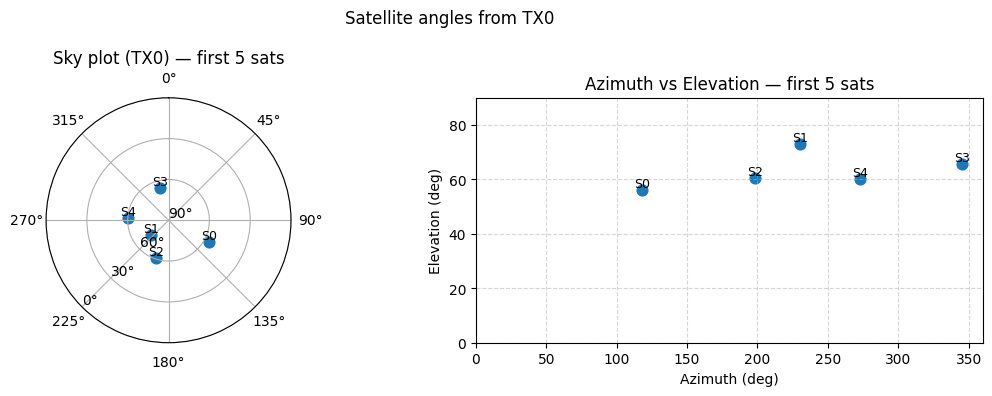

In [3]:
# Choose which ground TX viewpoint to use (0 = first one you printed)
tx_idx = 0

def sats_az_el_for_k(k, tx_pos):
    az_list, el_list = [], []
    for j in range(k):
        az, el, dist, n_waves = compute_az_el_dist(sat_positions[j], tx_pos, frequency_hz)
        az_list.append(float(az))
        el_list.append(float(el))
    return np.array(az_list), np.array(el_list)

# Plot for k = 5 (you can change to [3,4,5,6] if needed)
for k in [5]:
    az, el = sats_az_el_for_k(k, gnd_positions[tx_idx])

    fig = plt.figure(figsize=(11, 4))

    # ---- (Left) Polar sky plot: radius = 90 - elevation (0 at zenith) ----
    ax1 = plt.subplot(1, 2, 1, projection='polar')
    theta = np.deg2rad(az)      # azimuth in radians
    r = 90.0 - el               # zenith angle (0 at zenith, 90 at horizon)

    sc = ax1.scatter(theta, r, s=60)
    # annotate satellite indices
    for j in range(k):
        ax1.text(theta[j], r[j], f"S{j}", ha='center', va='bottom', fontsize=9)

    # Polar formatting: North up, clockwise azimuth; center=zenith, outer=horizon
    ax1.set_theta_zero_location("N")
    ax1.set_theta_direction(-1)
    ax1.set_rlim(0, 90)  # radius increases outward: 0 (zenith) -> 90 (horizon)

    # Show ring labels as Elevation (more intuitive)
    ax1.set_rticks([0, 30, 60, 90])                      # r values
    ax1.set_yticklabels(['90°', '60°', '30°', '0°'])     # corresponding elevation
    ax1.set_rlabel_position(225)                         # move labels to avoid overlap
    ax1.set_title(f"Sky plot (TX{tx_idx}) — first {k} sats")

    # ---- (Right) Cartesian azimuth vs elevation ----
    ax2 = plt.subplot(1, 2, 2)
    ax2.scatter(az, el, s=60)
    for j in range(k):
        ax2.text(az[j], el[j], f"S{j}", ha='center', va='bottom', fontsize=9)
    ax2.set_xlim(0, 360)
    ax2.set_ylim(0, 90)
    ax2.set_xlabel("Azimuth (deg)")
    ax2.set_ylabel("Elevation (deg)")
    ax2.grid(True, linestyle='--', alpha=0.5)
    ax2.set_title(f"Azimuth vs Elevation — first {k} sats")

    plt.suptitle(f"Satellite angles from TX{tx_idx}")
    plt.tight_layout()
    plt.show()


In [ ]:
from sionna.rt import Scene, Receiver, Transmitter, PlanarArray, PathSolver
import numpy as np

def compute_cir(tx_pos, rx_pos, tx_array, rx_array,tx_look_at, rx_look_at, frequency=10e9):
    """
    Compute CIR from a single transmitter to multiple receivers using synthetic arrays.
    
    Args:
        tx_pos:        (3,) list or np.array for transmitter position
        rx_pos_array:  (m,3) array of receiver positions
        tx_array:      PlanarArray for the transmitter
        rx_array:      PlanarArray for all receivers (shared)
        frequency:     Frequency in Hz

    Returns:
        a_list:    list of CIR amplitude arrays, one per RX
        tau_list:  list of delay arrays, one per RX
    """
    scene = Scene()
    scene.frequency = frequency
    scene.synthetic_array = True

    # Add transmitter
    scene.tx_array = tx_array
    tx = Transmitter(name="tx", position=tx_pos, display_radius=200)
    scene.add(tx)

    # Add receivers
    scene.rx_array = rx_array
    rx_list = []
    for i, rx_pos in enumerate(rx_pos):
        rx = Receiver(name=f"rx{i}", position=rx_pos)
        scene.add(rx)
        rx.look_at(rx_look_at)
        rx_list.append(rx)
    # tx_look_at = np.array(tx_pos) + np.array([0.0, 0.0, 100.0])
    tx.look_at( tx_look_at)  # Point TX to the first RX

    # Solve paths
    solver = PathSolver()
    paths = solver(scene=scene,
                   max_depth=0,
                   los=True,
                   synthetic_array=True,
                   seed=41)

    # Get CIRs
    a_all, tau_all = paths.cir(normalize_delays=False, out_type="numpy")

    for tx_name in scene.transmitters:
        scene.remove(tx_name)
    for rx_name in scene.receivers:
        scene.remove(rx_name) 
    
    return a_all, tau_all

import vsat_dish_3gpp
jam_rows =8
jam_cols = 8
jam_antennas = jam_cols*jam_rows

sat_rows = 1
sat_cols = 1
sat_antennas = sat_cols*sat_rows

tx_rows = 8
tx_cols = 8
tx_antennas = tx_cols*tx_rows

tx_array = PlanarArray(num_rows=tx_rows, num_cols=tx_cols,
                        vertical_spacing=0.5, horizontal_spacing=0.5,
                        pattern="tr38901", polarization="V")
                        # pattern="iso", polarization="V")

jam_array = PlanarArray(num_rows=jam_rows, num_cols=jam_cols,  
                            vertical_spacing=0.5, horizontal_spacing=0.5,
                        #  pattern="vsat_dish",
                            pattern="tr38901",
                            polarization="V")

sat_array = PlanarArray(num_rows=sat_rows, num_cols=sat_cols,
                             vertical_spacing=0.5, horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="V")




In [5]:


def collapse_channel(a_cir, t_idx=0):
    """
    Collapse channel tensor at a given time index.
    Input:
      a_cir: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
    Output:
      H_t: (M, N), M = num_rx*num_rx_ant, N = num_tx*num_tx_ant
    """
    nr, nra, nt, nta, npaths, ntimes = a_cir.shape
    assert 0 <= t_idx < ntimes
    H_t = a_cir[..., t_idx]             # select time slice
    H_t = H_t.sum(axis=-1)              # sum over paths
    H_t = H_t.reshape(nr*nra, nt*nta)   # merge Rx/Tx antennas
    return H_t




In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from minmax_solvers import (
    solve_game_mirror_prox,
    solve_game_bestresp_Q0_then_Q1,
    solve_game_proxBR,
    solve_game_extragradient,
    solve_game_pdhg
)
# Your utils
from leo_utils import arc_point_on_earth, compute_satellite_intersection_point_enu
from sionna.rt import PlanarArray
# from your_module import compute_cir, collapse_channel   # replace with your implementation



# -------------------------
# Experiment configuration
# -------------------------
methods = ["BestResp", "MirrorProx", "ProxBR", "ProxBRpp"]
# methods = [ "ProxBRpp"]
# methods = [ "ProxBR"]
sat_counts = [1,  3, 5]
# sat_counts = [ 6]
results = {m: {} for m in methods}

# -------------------------
# Main loop
# -------------------------
for m in methods:
    for k in tqdm(sat_counts, desc=f"Method={m}"):
        # Select the first k satellites
        sat_positions = []
        for az, el in angles[:k]:
            pos, delay, dist = compute_satellite_intersection_point_enu(az, el, sat_orbit_m)
            sat_positions.append(pos)
        sat_positions = np.array(sat_positions)

        # Build the channels
        a_tx, tau_tx = compute_cir(gnd_positions[0], sat_positions, tx_array, sat_array,
                                   sat_positions[0], gnd_positions[0])
        a_jam, tau_jam = compute_cir(gnd_positions[1], sat_positions, tx_array, sat_array,
                                     sat_positions[0], gnd_positions[0])
        H0 = collapse_channel(a_tx)
        H1 = collapse_channel(a_jam)

        N0 = noise_power_watt
        P0 = Tx_power_watt
        P1 = Jam_power_watt
        n1 = H1.shape[1]
        Q1_init = (P1/n1) * np.eye(n1, dtype=complex)

        # Run different solvers
        if m == "BestResp":
            Q0, Q1, n_it, hist = solve_game_bestresp_Q0_then_Q1(
                H0, H1, N0,
                P0=P0, P1=P1,
                max_outer=1000, tol=1e-6, inner_Q1_steps=4,
                geometry='entropy',        # 'euclidean' → Extragradient; 'entropy' → Mirror-Prox
                step_rule='adp',           # 'fixed' → fixed step size; 'adp' → adaptive step size
                eta=0.5,                   # used only when step_rule='fixed'
                eta_init=0.3,              # initial step size for adaptive mode
                eta_min=1.5e-1, eta_max=0.9, # range of step size for adaptive mode
                beta=0.1, gamma=1.01,      # backtracking shrink/expand factors
                multi_stream=True,         # multi-stream water-filling for Q0
                verbose=True,              # print progress
                track_hist=True,           # record history curves
                Q1_init=Q1_init
            )
            results[m][k] = hist

        elif m == "MirrorProx":
            Q0, Q1, hist = solve_game_mirror_prox(
                H0, H1, N0, P0, P1,
                steps=8000,
                eta=0.25,                  # step size (try between 0.2–0.4)
                step_rule='adp',           # 'adp' (adaptive) is usually faster; fallback to 'fixed' if unstable
                beta=0.3, gamma=1.03,      # shrink/expand factors
                eta_min=1e-3, eta_max=1.0,
                strong_reg=0.0,            # if unstable, set ~1e-3
                Q0_init=None, Q1_init=Q1_init,
                use_averaging=True,
                eta_probe=0.2,
                verbose=True, track_hist=True
            )
            results[m][k] = hist

        elif m == "ProxBR":
            Q0, Q1, hist = solve_game_proxBR(
                H0, H1, N0, P0, P1,
                rho=1e-2,
                outer_steps=400, outer_tol=1e-6,
                inner_max=300, inner_tol=1e-6,
                eta0_inner=0.5,            # initial step size for inner updates
                beta=0.1, gamma=1.05,       # backtracking shrink/expand
                eta_min=1e-1, eta_max=1.0,
                eta_probe=0.1,             # step size for residual evaluation (“thermometer”)
                min_outer=5,               # prevent early stop at iteration 1
                verbose=True, track_hist=True
            )
            
        elif m == "ProxBRpp":
            Q0, Q1, hist = solve_game_proxBR_pp(
                H0, H1, N0, P0, P1,
                rho=1e-2,
                outer_steps=200, outer_tol=1e-6,
                inner_max=500, inner_tol=1e-6,
                eta0_inner=0.5,
                beta=0.3, gamma=1.05,
                eta_min=1e-2, eta_max=0.3,
                min_outer=5,
                verbose=True, track_hist=True,
                # 调整核心
                sigma=0.1,      # 内层更精确
                tau=5e-3,        # 放宽下降比例要求
                grow=1.05,        # 每次ρ翻倍稍快一点
                lam=1.0,
                pg_eta=0.1, proj_mode='eq',
                rho_max=5e-2,     # 提高ρ上限，给它更多空间
                freeze_backtrack_at=5e-5  # 末期冻结更早
            )

            
        results[m][k] = hist


Method=BestResp:   0%|          | 0/3 [00:00<?, ?it/s]

[outer 1] errQ0=nan, errQ1=3.224e-02, res=3.289e-02, J=0.5880, eta=0.312, trQ1=100.000000
[outer 2] errQ0=6.498e-16, errQ1=2.985e-02, res=2.916e-02, J=0.5101, eta=0.325, trQ1=100.000000
[outer 3] errQ0=6.474e-16, errQ1=2.804e-02, res=2.633e-02, J=0.4538, eta=0.338, trQ1=100.000000
[outer 4] errQ0=6.800e-16, errQ1=2.665e-02, res=2.409e-02, J=0.4106, eta=0.352, trQ1=100.000000
[outer 5] errQ0=6.617e-16, errQ1=2.555e-02, res=2.226e-02, J=0.3763, eta=0.366, trQ1=100.000000
[outer 6] errQ0=6.983e-16, errQ1=2.467e-02, res=2.072e-02, J=0.3481, eta=0.381, trQ1=100.000000
[outer 7] errQ0=6.157e-16, errQ1=2.394e-02, res=1.941e-02, J=0.3244, eta=0.396, trQ1=100.000000
[outer 8] errQ0=9.635e-16, errQ1=2.335e-02, res=1.827e-02, J=0.3042, eta=0.412, trQ1=100.000000
[outer 9] errQ0=6.916e-16, errQ1=2.285e-02, res=1.727e-02, J=0.2867, eta=0.429, trQ1=100.000000
[outer 10] errQ0=5.809e-16, errQ1=2.243e-02, res=1.638e-02, J=0.2712, eta=0.447, trQ1=100.000000
[outer 11] errQ0=1.005e-15, errQ1=2.207e-02, 

Method=MirrorProx:   0%|          | 0/3 [00:00<?, ?it/s]

[0001] J=0.0164, errQ0=2.60e-03, errQ1=2.21e-04, res=2.38e-03, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0002] J=0.0191, errQ0=3.01e-03, errQ1=2.56e-04, res=2.75e-03, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0003] J=0.0221, errQ0=3.47e-03, errQ1=2.96e-04, res=3.17e-03, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0004] J=0.0255, errQ0=4.00e-03, errQ1=3.42e-04, res=3.64e-03, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0005] J=0.0295, errQ0=4.59e-03, errQ1=3.94e-04, res=4.17e-03, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0006] J=0.0339, errQ0=5.26e-03, errQ1=4.53e-04, res=4.77e-03, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0007] J=0.0390, errQ0=6.00e-03, errQ1=5.20e-04, res=5.42e-03, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0008] J=0.0446, errQ0=6.82e-03, errQ1=5.94e-04, res=6.15e-03, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0009] J=0.0509, errQ0=7.71e-03, errQ1=6.76e-04, res=6.94e-03, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0010] J=0.0579, errQ0=8.69e-03, errQ1=7.67e-04, res=7.78e-03, eta=0.25, trQ0=1.00

Method=ProxBR:   0%|          | 0/3 [00:00<?, ?it/s]

[001] J=0.2663, errQ0=1.00e+00, errQ1=4.91e+00, res=3.41e-02, trQ1=4.9110
[002] J=0.1982, errQ0=5.66e-16, errQ1=3.79e-01, res=1.89e-02, trQ1=6.7717
[003] J=0.1678, errQ0=7.77e-16, errQ1=1.95e-01, res=1.35e-02, trQ1=8.0906
[004] J=0.1496, errQ0=4.73e-16, errQ1=1.29e-01, res=1.08e-02, trQ1=9.1327
[005] J=0.1372, errQ0=5.27e-16, errQ1=9.55e-02, res=9.04e-03, trQ1=10.0052
[010] J=0.1059, errQ0=9.92e-16, errQ1=4.09e-02, res=5.38e-03, trQ1=13.1155
[020] J=0.0827, errQ0=4.53e-16, errQ1=1.88e-02, res=3.28e-03, trQ1=16.9487
[030] J=0.0718, errQ0=7.26e-16, errQ1=1.21e-02, res=2.47e-03, trQ1=19.6033
[040] J=0.0650, errQ0=5.42e-16, errQ1=8.96e-03, res=2.03e-03, trQ1=21.7036
[050] J=0.0602, errQ0=5.02e-16, errQ1=7.09e-03, res=1.74e-03, trQ1=23.4707
[060] J=0.0566, errQ0=6.90e-16, errQ1=5.87e-03, res=1.54e-03, trQ1=25.0116
[070] J=0.0537, errQ0=1.63e-15, errQ1=5.00e-03, res=1.38e-03, trQ1=26.3870
[080] J=0.0513, errQ0=4.18e-16, errQ1=4.36e-03, res=1.26e-03, trQ1=27.6352
[090] J=0.0493, errQ0=3.06e-1

Method=ProxBRpp:   0%|          | 0/3 [00:00<?, ?it/s]

[001] J=0.2079, ||G||_prox=2.06e-02, errQ0=1.00e+00, errQ1=1.34e+01, rho=0.01
[002] J=0.1765, ||G||_prox=1.49e-02, errQ0=9.63e-16, errQ1=9.27e-02, rho=0.01
[003] J=0.1578, ||G||_prox=1.19e-02, errQ0=6.04e-16, errQ1=6.99e-02, rho=0.01
[004] J=0.1450, ||G||_prox=1.00e-02, errQ0=8.61e-16, errQ1=5.65e-02, rho=0.01
[005] J=0.1355, ||G||_prox=8.75e-03, errQ0=1.04e-15, errQ1=4.76e-02, rho=0.01
[010] J=0.1088, ||G||_prox=5.64e-03, errQ0=5.07e-16, errQ1=2.70e-02, rho=0.01
[020] J=0.0867, ||G||_prox=3.58e-03, errQ0=5.45e-16, errQ1=1.48e-02, rho=0.01
[030] J=0.0759, ||G||_prox=2.74e-03, errQ0=5.28e-16, errQ1=1.02e-02, rho=0.01
[040] J=0.0689, ||G||_prox=2.26e-03, errQ0=3.91e-16, errQ1=7.83e-03, rho=0.01
[050] J=0.0640, ||G||_prox=1.95e-03, errQ0=5.92e-16, errQ1=6.35e-03, rho=0.01
[060] J=0.0602, ||G||_prox=1.73e-03, errQ0=7.16e-16, errQ1=5.34e-03, rho=0.01
[070] J=0.0572, ||G||_prox=1.56e-03, errQ0=5.96e-16, errQ1=4.61e-03, rho=0.01
[080] J=0.0547, ||G||_prox=1.43e-03, errQ0=5.08e-16, errQ1=4.06e

Text(0.5, 1.0, 'prox-gradient residual')

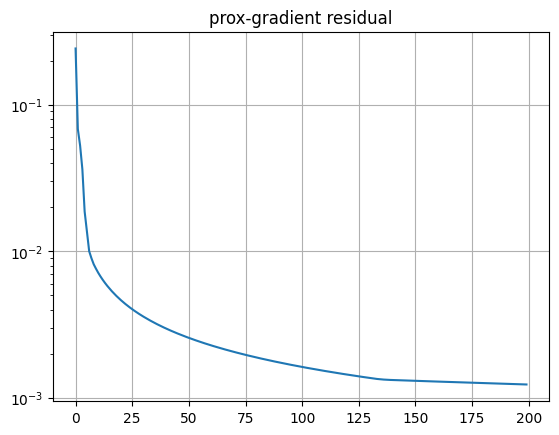

In [7]:
# 主收敛曲线：应基本单调下降
plt.semilogy(hist['res_prox']); plt.grid(True); plt.title('prox-gradient residual')

# 目标值仅作为参考观测（可能会锯齿）
# plt.plot(hist['J']); plt.grid(True); plt.title('J trajectory (reference)')


In [8]:
sat_counts

[1, 3, 5]

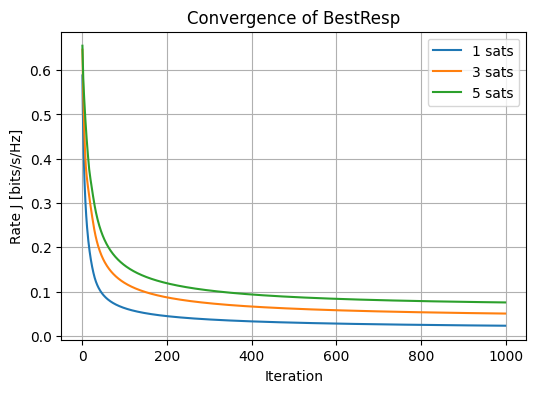

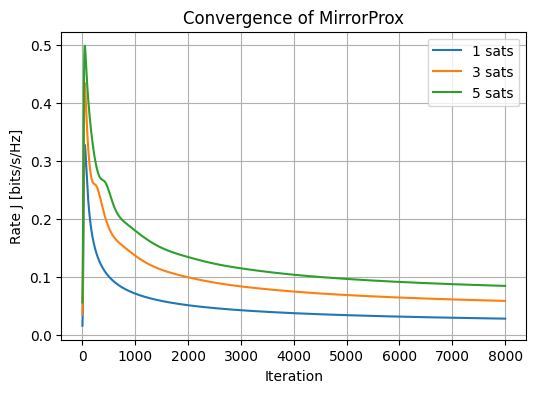

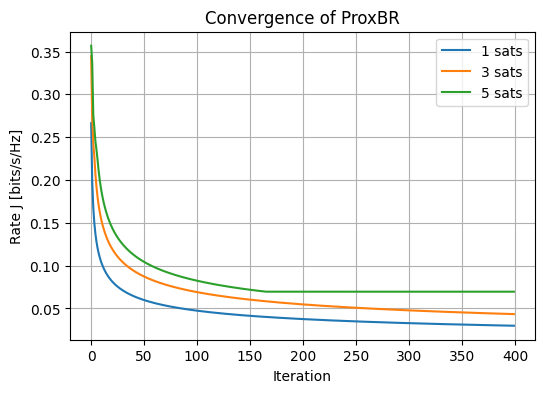

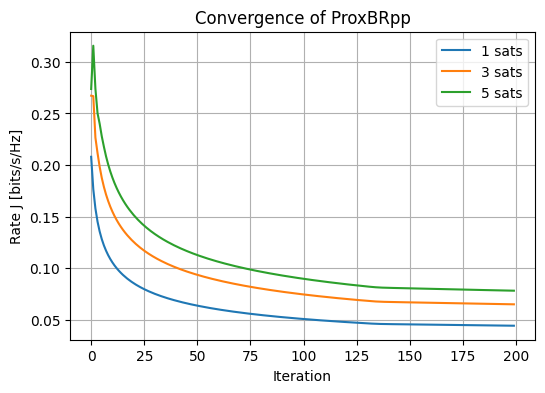

In [11]:

# # -------------------------
# # Plot for convergence
# # -------------------------
for m in methods:
    plt.figure(figsize=(6,4))
    for k in sat_counts:
        hist = results[m][k]
        plt.plot(hist['J'], label=f"{k} sats")
    plt.xlabel("Iteration")
    plt.ylabel("Rate J [bits/s/Hz]")
    plt.title(f"Convergence of {m}")
    plt.legend()
    plt.grid(True)
    plt.show()


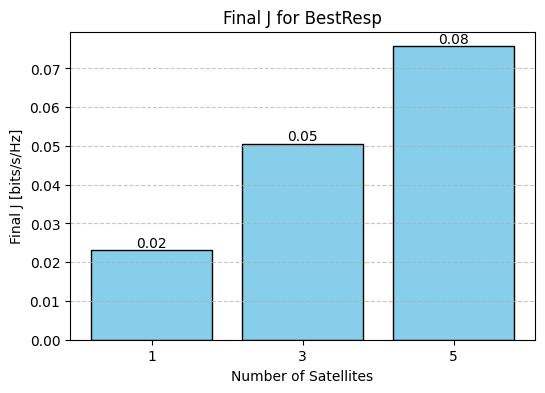

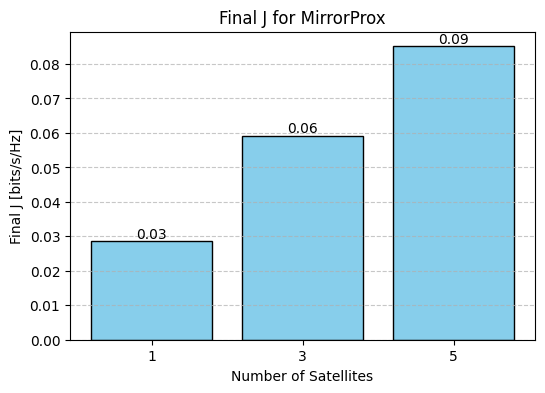

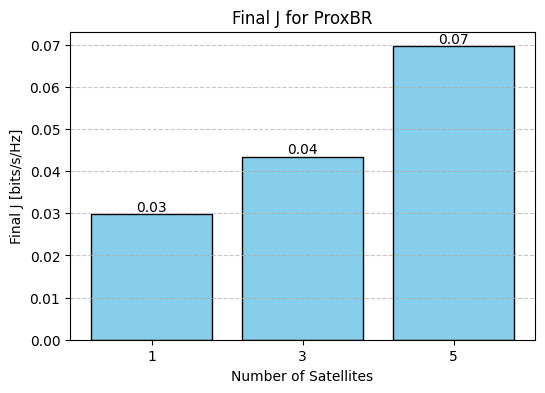

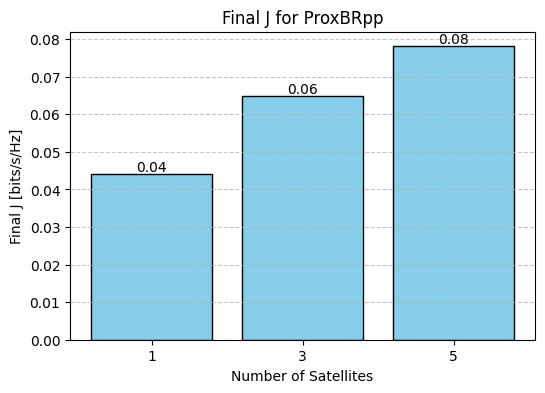

In [12]:
import matplotlib.pyplot as plt
import numpy as np



for m in methods:
    final_J = [results[m][k]['J'][-1] for k in sat_counts]
    plt.figure(figsize=(6,4))
    plt.bar([str(k) for k in sat_counts], final_J, color="skyblue", edgecolor="k")
    plt.xlabel("Number of Satellites")
    plt.ylabel("Final J [bits/s/Hz]")
    plt.title(f"Final J for {m}")
    for i, v in enumerate(final_J):
        plt.text(i, v, f"{v:.2f}", ha="center", va="bottom", fontsize=10)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()
